# Maximum Likelihood Formulation


$P(K|r) = \prod_{f} P(K_f|r)  $    ***We want to find the region $r$ that maximizes P(K).***

$P(K_f|r) = \sum_{g_m,g_p \epsilon G} P(g_p|k_p)P(g_m|k_m) \prod_{c}P(k_{c}|g_{phase}(g_{p}, g_{m})) $  Expression for likelihood of family k-mer distribution.

$P(g_i|k) = \frac{P(k|g_i)}{\sum_{g_i\epsilon G} P(k|g_i)}  $  

Convert to log probability.

$log(P(K|r)) =  \sum_{fams}  \left ( log \sum_{g_{m_f}}\sum_{g_{p_f}} \prod_{c_f} P(k_{c_f}|g_p,g_m) - log \sum_{g_{p_f}} P(k_{p_f}|g_{p_f}) -  log \sum_{g_{m_f}} P(k_{m_f}|g_{m_f}) \right )$

$G = \left \{ 0/0,0/1,1/0,1/1 \right \}  $  Set of possible phased genotypes for k-mer.

$K$ = Distribution of a k-mer 

$r$ = region 

$f$ = family 

$c$ = children 

$g$ = phased genotype of k-mer 

$G$ = set of possible phased genotypes 

$g_{phase}$ = Phasing dictionary from Kelley's algorithm 

In [6]:
from scipy.stats import poisson
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from collections import Counter
import matplotlib.pyplot as plt
from glob import glob
import json

In [7]:
poisson_cache = [[], []]
poisson_cache_length=100
avg_kmer_depth=7.05
poisson_cache[0] = [poisson.pmf(k=k, mu=avg_kmer_depth) for k in range(poisson_cache_length)]
poisson_cache[1] = [poisson.pmf(k=k, mu=2*avg_kmer_depth) for k in range(poisson_cache_length)]

cached_family_log_likelihood = dict()

def cached_poisson_pmf(k,g, avg_kmer_depth=avg_kmer_depth, eps=0, poisson_cache_length=poisson_cache_length):
    if (g==0) & (k!=0):
        return eps
    if (k==0) & (g==0): 
        return 1-3*eps #poisson.pmf(g*avg_kmer_depth, k)
    else:
        return min(max(poisson_cache[g-1][k], eps), 1-3*eps)

def prob_k_g_obs(k, g_obs, phasing_error_rate = .05):
    #P(k|0)
    
    
def family_log_likelihood(k_m, k_p, k_cs, phases_ch, min_prob=-10):
    
    '''
    Returns the probability of a k-mer distribution in a family given the each member's kmer counts and the children's phasings. Note: takes about 1 second per 50K family-regions.

            Parameters:
                    k_m (int): mom_kmer_count (int): A decimal integer
                    k_p (int): dad_kmer_count (int): Another decimal integer
                    phases_ch (list): A list of of tuples representing each child's phasings (mom's chromome, dad's chromosme) {(0,0), (0,1), (1,0), (1,1)}
                    avg_kmer_depth (int): Mean for avg k-mer depth of poisson distribution.

            Returns:
                    log likelihood (float): The log of the probability of the family's k-mer distribution given the famiy genotypes.
    '''    
    
    key = tuple(sorted([(k_m, k_p, k,g[0], g[1]) for k,g in zip(k_cs, phases_ch)]))
    if key in cached_family_log_likelihood: log_P = cached_family_log_likelihood[key]
    else:
        possible_gs = [(0,0), (1,1), (0,1), (1,0)]
        log_P_m = np.log2(sum([cached_poisson_pmf(k_m, g) for g in [0,1,1,2]]))
        log_P_p= np.log2(sum([cached_poisson_pmf(k_p, g) for g in [0,1,1,2]]))
        log_P_ch = np.log2(sum([cached_poisson_pmf(k_m,sum(g_m))*cached_poisson_pmf(k_p,sum(g_p))*
                                np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) 
                                         for k_c, phase_ch in zip(k_cs, phases_ch)]) for g_p in possible_gs for g_m in possible_gs]))
        log_P = log_P_ch-log_P_m-log_P_p
        cached_family_log_likelihood[key] = log_P
        
        if log_P>0: print("ERROR: log likelihood cannot be > 0")
    return log_P


IndentationError: expected an indented block (<ipython-input-7-f8d93a9dd32e>, line 21)

# Test pipeline on a ground truth k-mers.

In [3]:
PHASINGS_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/'
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'
KMER_COUNTS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/results/simulated_data/kmer_counts.tsv'

# Load coordinates for ground truth k-mers.

In [4]:
#PHASINGS_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/'
#BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'
#KMER_COUNTS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/ground_truth/sample_kmer_matrix/kmers.filt.tsv'
#KMERS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/ground_truth/sample_kmer_matrix/known_alt_haplotype_kmers_filt.txt'

In [ ]:
ref_genome = {r.id:r.description for r in SeqIO.parse(
    '/home/groups/dpwall/briannac/general_data/reference_genomes/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa', 'fasta')}

# Load phasings/haplotype information

In [5]:
# Load in family region/global region conversion data.
fam_region_to_idx = np.load(PHASINGS_DIR +  'fam_region_to_idx.npy', allow_pickle=True).item()
idx_to_fam_region = np.load(PHASINGS_DIR +  'idx_to_fam_region.npy', allow_pickle=True).item()
global_region_to_idx = np.load(PHASINGS_DIR +  'global_region_to_idx.npy', allow_pickle=True).item()
idx_to_global_region = np.load(PHASINGS_DIR +  'idx_to_global_region.npy', allow_pickle=True).item()
fam_region_to_global_region = np.load(PHASINGS_DIR + 'fam_regions_to_global_regions.npy', allow_pickle=True)
family_info = pd.read_pickle(PHASINGS_DIR + 'fam_list.df')

# Info from BAM mappings.
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']
sample_id_to_participant = {sample_id:participant_id for participant_id, sample_id in zip(bam_mappings.participant_id, bam_mappings.index)}

NameError: name 'np' is not defined

In [9]:
# Load in k-mer counts.
KMERS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/ground_truth/sample_kmer_matrix/known_alt_haplotype_kmers_filt.txt'
kmer_counts = pd.read_table(KMER_COUNTS_FILE, header=None, index_col=0, nrows=100000)
#kmer_names = pd.read_table(KMERS_FILE, header=None, index_col=0, nrows=100000)
kmer_counts.index = [(i,j) for i,j in zip(kmer_names.index, kmer_names[1])]
kmer_counts.columns = bam_mappings.index
kmer_counts = kmer_counts[((kmer_counts>0).mean(axis=1)>.05) & ((kmer_counts>0).mean(axis=1)<.5)]
#kmer_names = kmer_names.loc[kmer_counts.index]

In [27]:
def global_likelihoods(kmer_counts):
    final_likelihoods = {}
    families_in_file = [i.replace('.txt', '').split('/')[-1] for i in glob(
        '/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/*.txt')]
    for k in kmer_counts.iterrows():
        if k[0][1][3]=='1': continue
        print(k[0])
        global_likelihoods = [] #np.zeros(len(global_region_to_idx)) 
        fams_included = set(bam_mappings.loc[kmer_counts.columns[k[1]>0]].family).intersection(family_info.index).intersection(families_in_file)
        for fam in tqdm(list(fams_included)):  

            global_likelihood = np.zeros(len(global_region_to_idx)) 
            # Extract mom, dad, and child sample_ids.
            children = family_info.loc[fam].sib_samples
            mom = family_info.loc[fam].mother_sample
            dad = family_info.loc[fam].father_sample
            phased_fam = pd.read_csv('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/%s.txt' % fam,
                                     sep='\t')

            # Set up phasing dataframe.
            for ch in children:
                phased_fam[ch] = [(m,d-2) for m,d in zip(phased_fam[sample_id_to_participant[ch]+'_mat'], phased_fam[sample_id_to_participant[ch]+'_pat'])]
            phased_fam.index = ['%s.%09d.%09d' % (('0' + chrom[3:])[-2:].replace('0X', 'XX'), start, end) for chrom, start, end in phased_fam[['chrom', 'start_pos', 'end_pos']].values]
            #phased_fam = phased_fam[children]

            # Compute family likelihood.
            fam_likelihood = [family_log_likelihood(k[1][mom], k[1][dad], k[1][children], phased_fam[children].iloc[i]) for i in range(len(phased_fam))]

            # Convert family likelihood region to global region. 
            for i,l in enumerate(fam_likelihood):
                global_idxs = fam_region_to_global_region[fam_region_to_idx[phased_fam.index[i]]]
                global_likelihood[global_idxs] =  l
            global_likelihood[global_likelihood==0] = np.mean(global_likelihood[global_likelihood!=0])
            global_likelihoods = global_likelihoods + [global_likelihood]

        final_likelihoods[k[0]] = np.array(global_likelihoods).sum(axis=0)}
        print([idx_to_global_region[i] for i in np.argsort(final_likelihood)[::-1][:100:10]])
    return final_likelihoods

  0%|          | 0/131 [00:00<?, ?it/s]

('ATCCATCTATCATTTATCTATATGGTATATATCTATTAATCATCTATTTATTCATTTATTATCTATCTAGCCATCATCTATCATTTATCGATTATCCATC', 'chr2_KI270770v1_alt')


100%|██████████| 131/131 [01:27<00:00,  1.49it/s]

['09.104599158.104599168', '09.106390746.106390963', '16.016579999.016580174', '09.106392142.106401422', '16.016569574.016569700', '09.106534603.106535307', '09.104865908.104866612', '09.105647425.105647426', '09.105924149.105971685', '09.106250008.106301140']


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


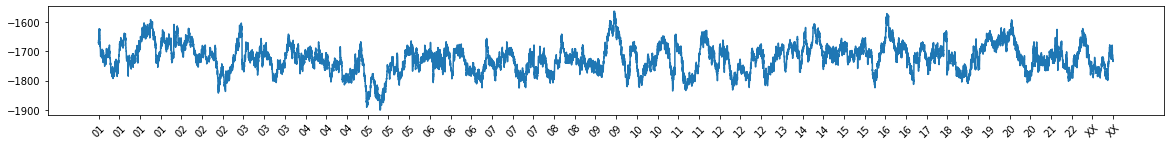

In [29]:
plt.figure(figsize=(20,2))
print(plt.xticks())
prob = 2**final_likelihood
prob=prob/sum(prob)
plt.plot(final_likelihood)
ticks = np.linspace(0,len(final_likelihood)-1, num=50)
label = [idx_to_global_region[int(aa)][:2] for aa in ticks]
plt.xticks(ticks, label,rotation=45)
plt.show()

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


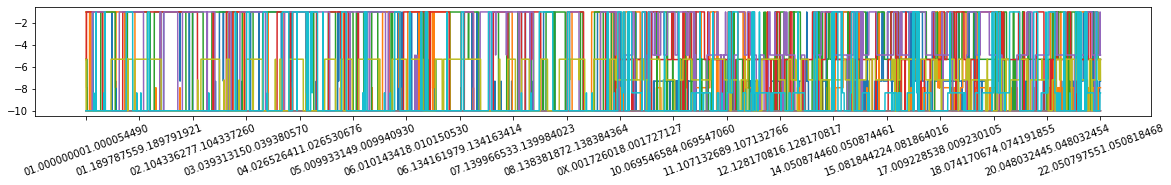

In [578]:
plt.figure(figsize=(20,2))
print(plt.xticks())
prob = 2**final_likelihood
prob=prob/sum(prob)
for g in global_likelihoods:
    plt.plot(g)
ticks = np.linspace(0,len(final_likelihood)-1, num=20)
label = [idx_to_global_region[int(aa)] for aa in ticks]
plt.xticks(ticks, label,rotation=20)
plt.show()

In [ ]:
[frozenset([frozenset(children[np.where(np.array(i)==True)[0]]), frozenset(children[np.where(np.array(i)==False)[0]])]) for i in df_mat.index]


# Match phasings to kmers

In [41]:
global_vote = np.zeros((len(kmer_counts), len(global_region_to_idx)))
global_vote

In [595]:
len(global_likelihood)

225313

In [4]:
# Load in family region/global region conversion data.
with open('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/phasings/' + 'fam_regions_to_global_regions_21.json', 'r') as f:
    fam_regions_to_global_regions = json.load(f)

In [59]:
PHASINGS_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/'


In [ ]:
# Load in family region/global region conversion data.
fam_region_to_idx = np.load(PHASINGS_DIR +  'fam_region_to_idx.npy', allow_pickle=True).item()
idx_to_fam_region = np.load(PHASINGS_DIR +  'idx_to_fam_region.npy', allow_pickle=True).item()
global_region_to_idx = np.load(PHASINGS_DIR +  'global_region_to_idx.npy', allow_pickle=True).item()
idx_to_global_region = np.load(PHASINGS_DIR +  'idx_to_global_region.npy', allow_pickle=True).item()

fam_region_to_global_region = np.load(PHASINGS_DIR + 'fam_regions_to_global_regions.npy', allow_pickle=True).item()

In [1]:
len(global_region_to_idx)

NameError: name 'global_region_to_idx' is not defined

# Create table/dictionary to convert family region to global region

In [4]:
# Load in phased regions.
import pandas as pd
import numpy as np
import sys
import json
import tqdm
from collections import Counter
FINAL_PHASINGS_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/phasings'


start_ends = pd.read_pickle(FINAL_PHASINGS_DIR + '/family_regions.df')
family_region_to_global_regions_dict = {}

In [39]:
with open(FINAL_PHASINGS_DIR + '/fam_regions_to_global_regions.json', 'w') as f:
    json.dump(family_region_to_global_regions_dict, f)        
        
# Combine all dictionaries.
#fam_regions_to_global_regions_full_dict = {}
#for chrom in range(22):
#    with open(PHASINGS_DIR + '/fam_regions_to_global_regions_%s.json' % chrom, 'r') as fp:
#        new_dict = json.load(fp)
#    fam_regions_to_global_regions_full_dict.update(new_dict)

#with open(FINAL_PHASINGS_DIR + '/fam_regions_to_global_regions.json', 'w') as f:
#    json.dump(family_region_to_global_regions_dict, f)

In [147]:
print('saving...')
with open(PHASINGS_DIR + '/fam_regions_to_global_regions_%s.json' % chrom, 'w') as f:
    json.dump(family_region_to_global_regions_dict, f)

saving...


In [54]:
mappings = np.load('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/fam_regions_to_global_regions.npy', allow_pickle=True)